In [1]:
import os 


In [2]:
img_path = "../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images"
mask_path = "../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/masks"
os.listdir(img_path) == os.listdir(mask_path)

True

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [4]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,1,1,bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels,out_channels,3,1,1,bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            
        )
    def forward(self,x):
        return self.conv(x)
    
         

In [5]:
class UNet(nn.Module):
    def __init__(self,in_channels,out_channels,features = [64,128,256,512]):
        super(UNet,self).__init__()
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        
        #Down Part
        for feature in features:
            self.down.append(DoubleConv(in_channels,feature))
            in_channels = feature
        #Up Part
        for feature in reversed(features):
            self.up.append(nn.ConvTranspose2d(
                feature*2,feature,kernel_size = 2 , stride = 2
            ))
            self.up.append(DoubleConv(feature*2,feature))
        self.bottleneck = DoubleConv(features[-1],features[-1]*2)
        self.final_conv = nn.Conv2d(features[0],out_channels,1)
    
    def forward(self,x):
        skip_connections = []
        for down in self.down:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0,len(self.up),2):
            x = self.up[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection,x),dim = 1)
            
            x = self.up[idx+1](concat_skip)
            
        
        return self.final_conv(x)
            
        
        
        

In [6]:
x = torch.randn((3,1,161,161))
model = UNet(1,1)
preds = model(x)
print(preds.shape)
print(x.shape)
assert preds.shape == x.shape

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


In [7]:
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class SFB(Dataset):
    def __init__(self,images,masks,transforms = None):
        self.images = images
        self.masks = masks
        self.transforms = transforms
    def __len__(self):
        return len(self.images)

    def __getitem__(self,ix):
        image = np.array(Image.open(self.images[ix]).convert("RGB"))
        mask = np.array(Image.open(self.masks[ix]).convert("L"))
        mask[mask == 255.0] = 1.0
        
        if self.transforms:
            augmentations = self.transforms(image = image,mask = mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            
        return image,mask
        
        

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
def train_fn(loader,model,optimizer,loss_fn,scaler):
    loop = tqdm(loader)
    model.train()
    for batch_idx,(data,targets) in enumerate(loop):
        data = data.to(device = DEVICE)
        targets = targets.float().unsqueeze(1).to(device = DEVICE)
        
        with torch.cuda.amp.autocast():
            preds = model(data)
            loss = loss_fn(preds,targets)
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss=loss.item())
        
    

In [11]:
def check_accuracy(loader,model,device = "cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    
    

In [12]:
train_transform = A.Compose(
        [
            A.Resize(height=160, width=240),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
        [
            A.Resize(height=160, width=240),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [13]:
model = UNet(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
from glob import glob
train_img = glob("../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/*")[:1000]
train_mask = glob("../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/masks/*")[:1000]
val_img = glob("../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/*")[1000:]
val_mask = glob("../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/masks/*")[1000:]

In [15]:
train_data = SFB(train_img,train_mask,train_transform)
val_data = SFB(val_img,val_mask,val_transforms) 

In [16]:
im,mask = val_data[10]

In [17]:
from torch.utils.data import DataLoader

In [18]:
train_data_loader = DataLoader(train_data,batch_size = 16,num_workers = 2 , pin_memory = True,shuffle = True)
val_data_loader = DataLoader(val_data,batch_size = 16,num_workers = 2 , pin_memory = True,shuffle = False)

In [79]:
scaler = torch.cuda.amp.GradScaler()
for epoch in range(5):
    train_fn(train_data_loader,model,optimizer,loss_fn,scaler)
    check_accuracy(val_data_loader, model, device=DEVICE)

  0%|          | 0/63 [00:00<?, ?it/s]

Got 6693432/7372800 with acc 90.79
Dice score: 1.8455219268798828


  0%|          | 0/63 [00:00<?, ?it/s]

Got 6552118/7372800 with acc 88.87
Dice score: 1.8422274589538574


  0%|          | 0/63 [00:00<?, ?it/s]

Got 6704369/7372800 with acc 90.93
Dice score: 1.8198498487472534


  0%|          | 0/63 [00:00<?, ?it/s]

Got 6963286/7372800 with acc 94.45
Dice score: 1.86623215675354


100%|██████████| 63/63 [01:10<00:00,  1.13s/it, loss=-19.1]


Got 6907686/7372800 with acc 93.69
Dice score: 1.8330919742584229


In [26]:
def save_predictions_as_imgs(
    loader, model, folder=".", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        

    

In [94]:
import torchvision
import matplotlib.pyplot as plt

In [80]:
save_predictions_as_imgs(val_data_loader,model)

In [81]:
img = Image.open("./pred_11.png")

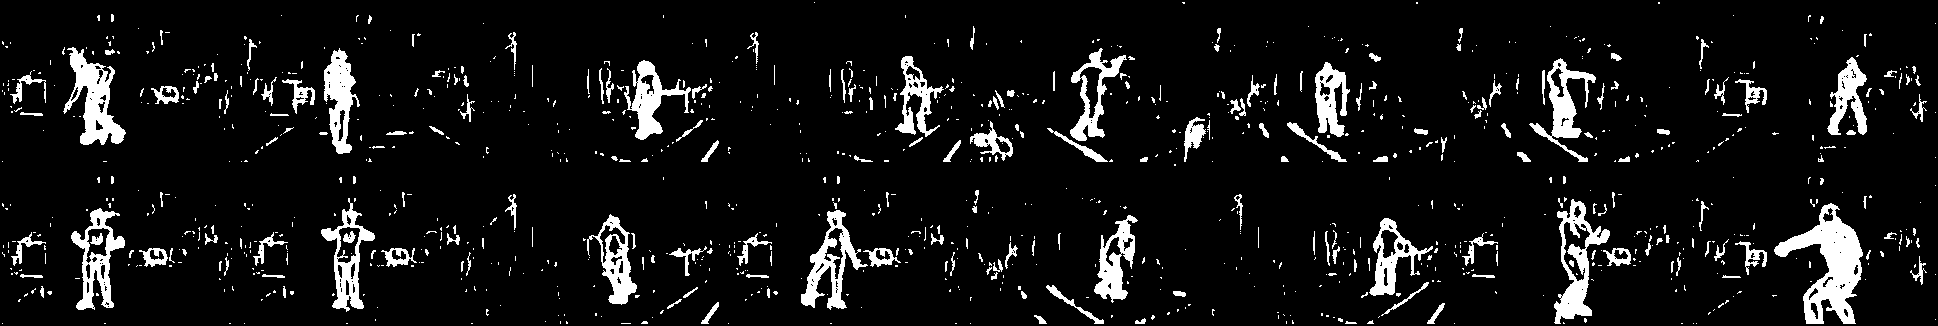

In [82]:
img

In [111]:
img,mask = val_data[20]
with torch.no_grad():
    
    preds = torch.sigmoid(model(img[None].to(DEVICE)))

In [112]:
preds = preds[0].cpu().permute(1,2,0).numpy()

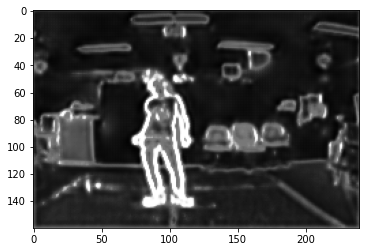

In [113]:
plt.imshow(preds,cmap = "gray")

In [114]:
x = os.listdir("../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/masks")[1020]
new_img = Image.open("../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/masks/"+x)

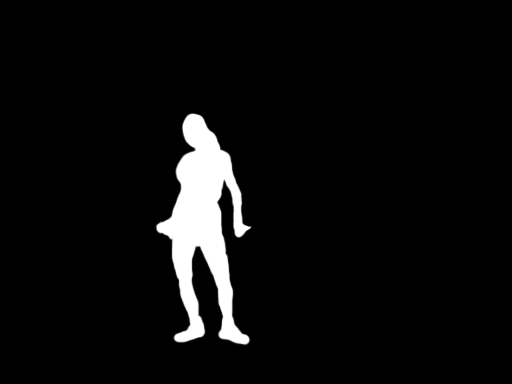

In [115]:
new_img